In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json

from tqdm import tqdm

In [7]:
DATA_IN_PATH='/content/drive/MyDrive/Project/korean_nlp_1/input_data/'
DATA_OUT_PATH='/content/drive/MyDrive/Project/korean_nlp_1/output_data/'
INPUT_TRAIN_DATA='nsmc_train_input.npy'
LABEL_TRAIN_DATA='nsmc_train_label.npy'
DATA_CONFIGS ='data_configs.json'

train_input = np.load(open(DATA_IN_PATH + INPUT_TRAIN_DATA, 'rb'))
train_input = pad_sequences(train_input, maxlen=train_input.shape[1])
train_label = np.load(open(DATA_IN_PATH + LABEL_TRAIN_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [8]:
model_name = 'cnn_classifier_kr'
BATCH_SIZE = 512
NUM_EPOCHS = 4
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {'model_name' : model_name,
         'vocab_size' : prepro_configs['vocab_size'],
         'embedding_size' : 128,
         'num_filters' : 100,
         'dropout_rate' : 0.5,
         'hidden_dimension' : 250,
         'output_dimension' : 1}
         

In [9]:
class CNNClassifier(tf.keras.Model):

    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name = kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
                                          output_dim=kargs['embedding_size'])
        self.conv_list = [layers.Conv1D(filters=kargs['num_filters'],
                                        kernel_size=kernel_size,
                                        padding='valid',
                                        activation=tf.keras.activations.relu,

kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
                    for kernel_size in[3,4,5]]
        self.pooling = layers.GlobalMaxPooling1D()
        self.dropout =layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units = kargs['hidden_dimension'],
                                activation = tf.keras.activations.sigmoid,
                                kernel_constraint = tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2 = layers.Dense(units = kargs['output_dimension'],
                                activation = tf.keras.activations.sigmoid,
                                kernel_constraint = tf.keras.constraints.MaxNorm(max_value=3.))
        
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=1)
        x = self.fc1(x)
        x = self.fc2(x)

        return x


In [10]:
model = CNNClassifier(**kargs)

model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

earlystop_callback = EarlyStopping(monitor = 'val_accuracy', min_delta=0.0001, patience=2)

checkpoint_path = DATA_OUT_PATH + model_name + '\weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

#Create path if exists

if os.path.exists(checkpoint_dir):
    print("{} == Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))

cp_callback =ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

history = model.fit(train_input, train_label, batch_size = BATCH_SIZE, epochs = NUM_EPOCHS, validation_split = VALID_SPLIT, callbacks = [earlystop_callback, cp_callback])

/content/drive/MyDrive/Project/korean_nlp_1/output_data == Folder already exists 

Epoch 1/4
264/264 [==============================] - ETA: 0s - loss: 0.4633 - accuracy: 0.7700
Epoch 1: val_accuracy improved from -inf to 0.82107, saving model to /content/drive/MyDrive/Project/korean_nlp_1/output_data/cnn_classifier_kr\weights.h5
264/264 [==============================] - 44s 158ms/step - loss: 0.4633 - accuracy: 0.7700 - val_loss: 0.3935 - val_accuracy: 0.8211
Epoch 2/4
264/264 [==============================] - ETA: 0s - loss: 0.3565 - accuracy: 0.8444
Epoch 2: val_accuracy improved from 0.82107 to 0.82500, saving model to /content/drive/MyDrive/Project/korean_nlp_1/output_data/cnn_classifier_kr\weights.h5
264/264 [==============================] - 42s 161ms/step - loss: 0.3565 - accuracy: 0.8444 - val_loss: 0.3882 - val_accuracy: 0.8250
Epoch 3/4
264/264 [==============================] - ETA: 0s - loss: 0.3052 - accuracy: 0.8712
Epoch 3: val_accuracy improved from 0.82500 to 0.8272

In [11]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val'+string])
    plt.show()

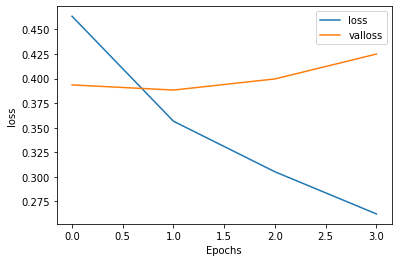

In [12]:
plot_graphs(history, 'loss')

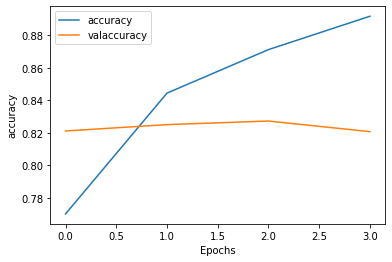

In [13]:
 plot_graphs(history, 'accuracy')

In [14]:
DATA_IN_PATH='/content/drive/MyDrive/Project/korean_nlp_1/input_data/'
DATA_OUT_PATH = '/content/drive/MyDrive/Project/korean_nlp_1/output_data'
INPUT_TEST_DATA = 'nsmc_test_input.npy'
LABEL_TEST_DATA = 'nsmc_test_label.npy'
SAVE_FILE_NM = 'weights.h5'

test_input = np.load(open(DATA_IN_PATH + INPUT_TEST_DATA, 'rb'))
test_input = pad_sequences(test_input, maxlen=test_input.shape[1])
test_label_data = np.load(open(DATA_IN_PATH + LABEL_TEST_DATA, 'rb'))

In [15]:
model.load_weights(os.path.join(DATA_OUT_PATH, 'cnn_classifier_kr\weights.h5'))
model.evaluate(test_input, test_label_data)

1563/1563 [==============================] - 9s 6ms/step - loss: 0.4005 - accuracy: 0.8266


[0.4005375802516937, 0.8265600204467773]